## EVALUATION

## Import Libraries

In [15]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, accuracy_score

import joblib


## Load Data

In [36]:
def load_data():
    X_train = pd.read_csv('../input/Train.csv', sep=',').set_index('id')
    X_val = pd.read_csv('../input/Val.csv', sep=',').set_index('id')
    X_test = pd.read_csv('../input/Test.csv', sep=',').set_index('id')
    return X_train, X_val, X_test


In [37]:
X_train, X_val, X_test = load_data()



In [38]:
X_test.head()

,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT,target
id,,,,,,,,,,,,,,
93952372,0.065237,-0.564595,1.127018,-0.087128,0.875601,0.251863,7.854928e-01,-0.405707,1.287916,0,0,1,0,0
15741465,1.211835,-0.564595,1.127018,-0.224658,-0.504480,0.778456,5.281836e-02,-0.606024,2.188266,1,0,0,0,0
55198988,-1.482670,-0.564595,-1.386813,-0.637249,0.507580,-0.985720,-1.626864e-16,-0.644090,-0.962959,0,0,0,1,0
16642377,-0.049423,1.771181,1.127018,0.256697,-0.504480,-0.178986,5.281836e-02,-0.503203,-0.512784,1,0,0,0,0
1562329,-0.671452,-0.564595,0.568389,-0.704790,0.691590,-0.170121,-1.626864e-16,-0.636304,-0.287696,0,0,0,1,0


In [39]:
X_test.columns


Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'addr_state', 'dti',
       'mths_since_recent_inq', 'bc_open_to_buy', 'num_op_rev_tl',
       'home_ownership_MORTGAGE', 'home_ownership_OTHERS',
       'home_ownership_OWN', 'home_ownership_RENT', 'target'],
      dtype='object')

## Load models

In [40]:


def load_models():
    models_names_short = ['gaussian', 'logreg', 'dectree', 'rndforest', 'gbc', 'xgb_classifier']

    # Nomes dos arquivos dos modelos
    model_files = {
        'modelo0': "../artifacts/" + models_names_short[0] + "_model.joblib",
        'modelo1': "../artifacts/" + models_names_short[1] + "_model.joblib",
        'modelo2': "../artifacts/" + models_names_short[2] + "_model.joblib",
        'modelo3': "../artifacts/" + models_names_short[3] + "_model.joblib",
        'modelo4': "../artifacts/" + models_names_short[4] + "_model.joblib",
        'modelo5': "../artifacts/" + models_names_short[5] + "_model.joblib",
    }

    # Carregar os modelos
    models = {name: joblib.load(path) for name, path in model_files.items()}
    return models



In [41]:
models = load_models()
# Agora você pode acessar cada modelo pelo seu nome, por exemplo:
gaussian = models['modelo0']
logreg = models['modelo1']
dectree = models['modelo2']
rndforest = models['modelo3']
gbc = models['modelo4']
xgb_classifier = models['modelo5']





In [ ]:

def plot_roc_curves(df00, models, model_names, info, figsize=(12,8)):
    """
    Plots ROC curves for a list of models.

    Parameters:
    X (numpy.ndarray or pandas.DataFrame): input features for the models
    y (numpy.ndarray or pandas.DataFrame): target variable
    models (list): list of models to compare
    model_names (list): list of model names to display on the plot
    info (string): info about validation or test dataset. 'validation' or 'test'
    figsize (tuple): size of the figure to display the plot

    Returns:
    None
    """
    X = df00.drop(columns=['target'])
    y = df00.target
    fig, ax = plt.subplots(figsize=figsize)
    models_ = []
    roc_auc_ = []
    # Loop over models and plot ROC curve
    for i, model in enumerate(models):
        y_pred = list(model.predict_proba(X)[:, 1])
        fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=(model_names[i] + ' AUC = %0.4f' % roc_auc), linewidth=2.0)
        models_.append(model_names[i])
        roc_auc_.append(roc_auc) 
    

    ax.grid(False)
    ax.tick_params(length=6, width=2, labelsize=15, grid_color='r', grid_alpha=0.5)
    leg = plt.legend(loc='lower right', prop={'size': 15})
    leg.get_frame().set_edgecolor('b')
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=20)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
#     plt.show()
    return (
    pd.DataFrame(data={
        'Model':models_,
        'AUC_'+info:roc_auc_,
    })
    )

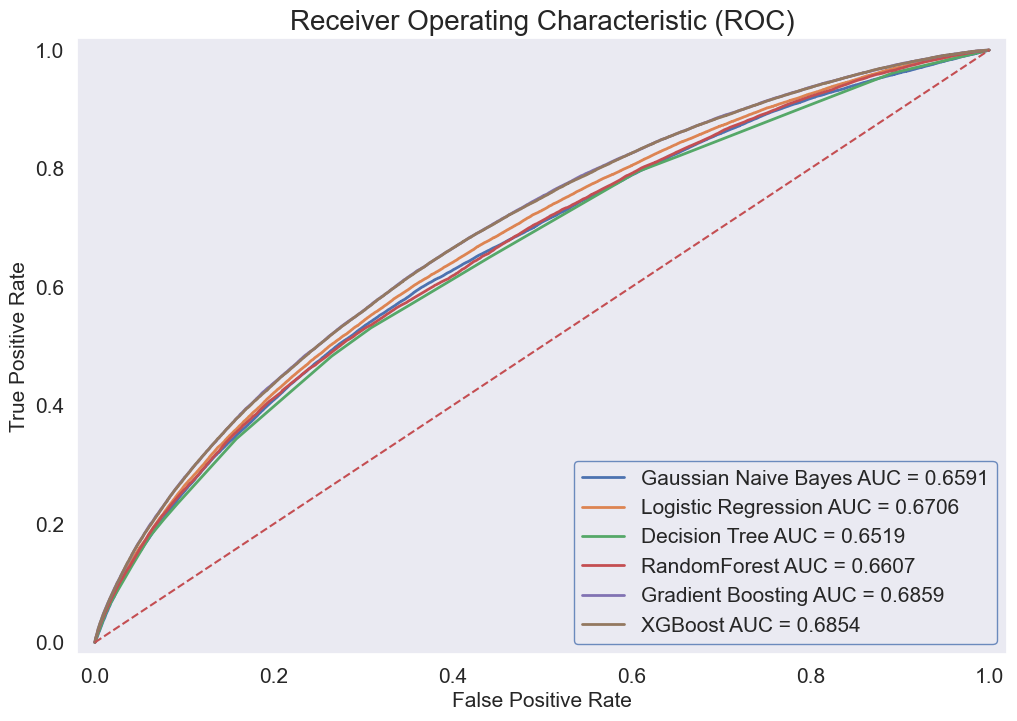

In [ ]:
# Define the list of models to compare
models = [gaussian, logreg, dectree, rndforest, gbc, xgb_classifier]
model_names = ['Gaussian Naive Bayes','Logistic Regression', 'Decision Tree', 'RandomForest', 'Gradient Boosting', 'XGBoost']
# Plot ROC curves for in-sample data
val_roc_auc = plot_roc_curves(X_val, models, model_names, info='validation')


,Models,AUC_test
0,Gaussian Naive Bayes,0.659490
1,Logistic Regression,0.671052
2,Decision Tree,0.651497
3,RandomForest,0.660199
4,Gradient Boosting,0.685604
5,XGBoost,0.685140


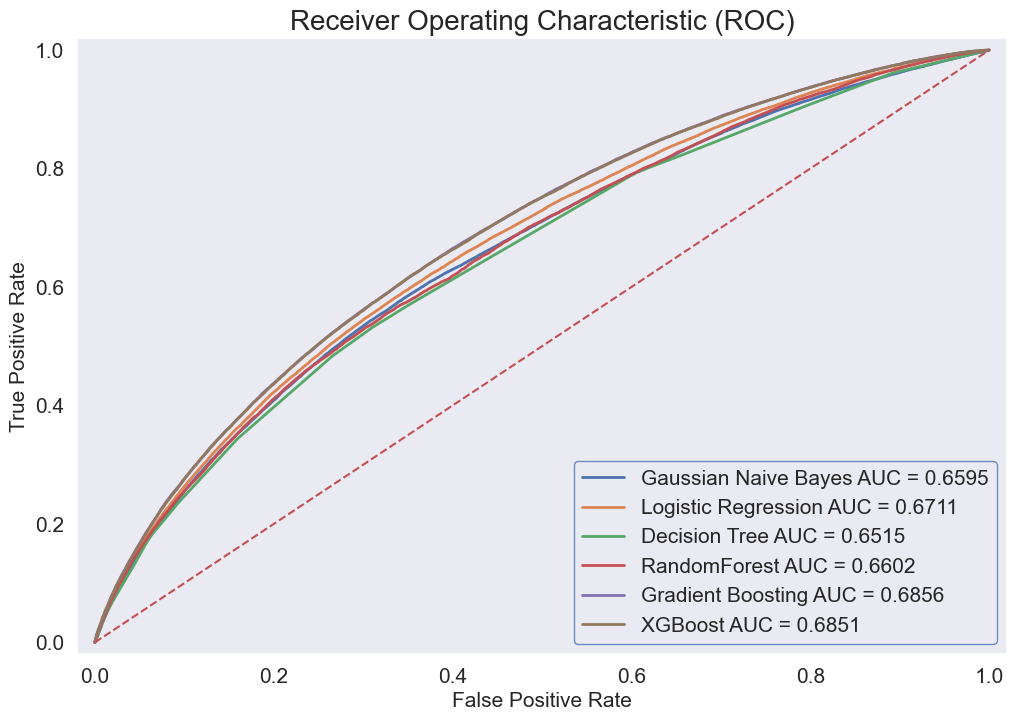

In [ ]:
# Plot ROC curves for out-of-sample data
test_roc_auc = plot_roc_curves(X_test, models, model_names, info='test')
test_roc_auc

## Best ROC AUC Model

In [72]:
auc_roc_table = pd.merge(val_roc_auc,test_roc_auc,how='left',on='Model').sort_values(by='AUC_test',ascending=False)
auc_roc_table

,Models,AUC_validation,AUC_test
4,Gradient Boosting,0.685898,0.685604
5,XGBoost,0.685420,0.685140
1,Logistic Regression,0.670632,0.671052
3,RandomForest,0.660713,0.660199
0,Gaussian Naive Bayes,0.659087,0.659490
2,Decision Tree,0.651922,0.651497


### Optimal threshold

In [73]:

# Define a function to find the best threshold for a given model
def find_best_threshold(df00, model, num_steps):
    X_val = df00.drop(columns=['target'])
    y_val = df00.target
    highest_f1 = 0
    best_threshold = 0
    best_acc = 0
    best_rec = 0
    best_pre = 0
    # Iterate over a range of thresholds
    for threshold in np.linspace(0, 1, num_steps):
        # Predict the target variable using the given threshold
        y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
        # Calculate various evaluation metrics
        f1 = f1_score(y_val, y_predict)
        acc = accuracy_score(y_val, y_predict)
        rec = recall_score(y_val, y_predict)
        pre = precision_score(y_val, y_predict)
        # Update the best threshold and metrics if F1 score improves
        if f1 > highest_f1:
            best_threshold, highest_f1, best_acc, best_rec, best_pre = \
                threshold, f1, acc, rec, pre
    # Return the best threshold and evaluation metrics
    return best_threshold, highest_f1, best_acc, best_rec, best_pre

In [74]:


# Create an empty list to store the results
chart = list()

# Iterate over the models and find the best threshold for each one
for item, name in zip(models, model_names):
    best_thresh, high_f1, high_acc, high_rec, high_pre = find_best_threshold(X_val, item, 20)
    # Append the results to the chart list
    chart.append([name, best_thresh, high_f1, high_acc, high_rec, high_pre])

# Create a pandas dataframe from the chart list and display it
chart = pd.DataFrame(chart, columns=['Model', 'Best Threshold', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])
# chart.to_csv('model_evaluation_scores.csv')
chart

In [ ]:
decision_table = pd.merge(auc_roc_table,chart, how='left', on='Model')
decision_table

### Confusion Matrix

In [52]:
def make_confusion_matrix_val(df00, model, threshold=0.5):
    """
    Create a confusion matrix plot for the given model and threshold. 
    
    Parameters:
    -----------
    model : sklearn classifier
        The classification model to evaluate.
    threshold : float, default=0.5
        Probability threshold for binary classification.
        
    Returns:
    --------
    None
    
    """
    X_val = df00.drop(columns=['target'])
    y_val = df00.target
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    
    # calculate the confusion matrix
    _confusion = confusion_matrix(y_val, y_predict)
    
    # plot the confusion matrix as heatmap
    plt.figure(dpi=100)
    sns.set(font_scale=1)
    sns.heatmap(_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Default', 'Default'],
           yticklabels=['Not Default', 'Default']);
    
    # calculate TP, FP, FN, and TN values from the confusion matrix
    TP = _confusion[0][0]
    FP = _confusion[0][1]
    FN = _confusion[1][0]
    TN = _confusion[1][1]

    tot = TP+FP+FN+TN
    print(FN/(tot),TN/(tot), FN/(tot) + TN/(tot))
    
    # rotate y-axis ticks
    plt.yticks(rotation = 0)
    
    # set plot title, x and y labels
    plt.title('Predicted vs. Actual',
            # fontname = '.SF Compact Display',
            fontsize = 20,pad = 10);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [53]:
def make_confusion_matrix_test(df00, model, info='num', threshold=0.5):
    """
    Generates a confusion matrix for a given model on the test dataset, given a threshold.

    Args:
    - model: a trained machine learning model
    - info: plot num or perc in confusion matrix
    - threshold: threshold for binary classification

    Returns: None
    """
    X_test = df00.drop(columns=['target'])
    y_test = df00.target
    # Predict class 1 if probability of being in class 1 is greater than threshold
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)

    # Generate confusion matrix
    _confusion = confusion_matrix(y_test, y_predict)

    # Plot heatmap of confusion matrix
    plt.figure(dpi=100)
    sns.set(font_scale=1)
    if info=='num':
        sns.heatmap(_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
                    xticklabels=['Not Default', 'Default'],
                    yticklabels=['Not Default', 'Default'])
    else:
        sns.heatmap(_confusion/np.sum(_confusion), cmap=plt.cm.Blues, annot=True, 
                    square=True, 
                    fmt='.3%',
                    xticklabels=['Not Default', 'Default'],
                    yticklabels=['Not Default', 'Default'])

    # Calculate TP, FP, FN, TN
    TP = _confusion[0][0]
    FP = _confusion[0][1]
    FN = _confusion[1][0]
    TN = _confusion[1][1]
    
    tot = TP+FP+FN+TN
    print(round(100*FN/(tot),2),round(100*TN/(tot),2), round(100*(FN/(tot) + TN/(tot)),2))
    
    # Add title, labels and rotate y-tick labels
    plt.yticks(rotation=0)
    plt.title('Predicted vs. Actual', 
    fontsize=20, pad=10)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

### Confusion Matrix for Random Forest 

0.0925177096728635 0.10710914213080999 0.1996268518036735


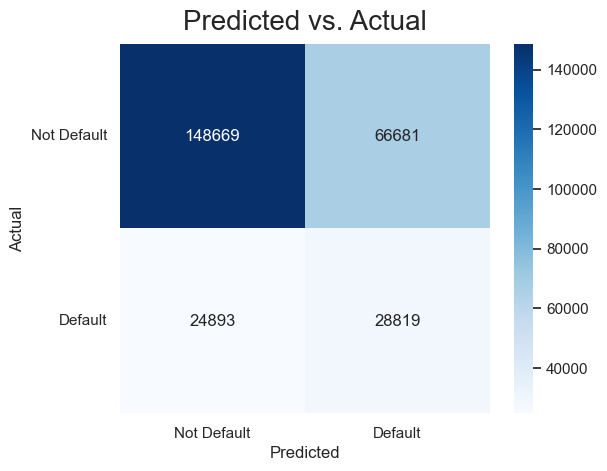

In [54]:
# Create a confusion matrix for the Random Forest model with a threshold of 0.474 on the validation data
make_confusion_matrix_val(X_val, rndforest, threshold=0.210526)

# Save the plot as PNG file
# plt.savefig('confusion_matrix_val_random_forest.png');

9.24 10.72 19.96


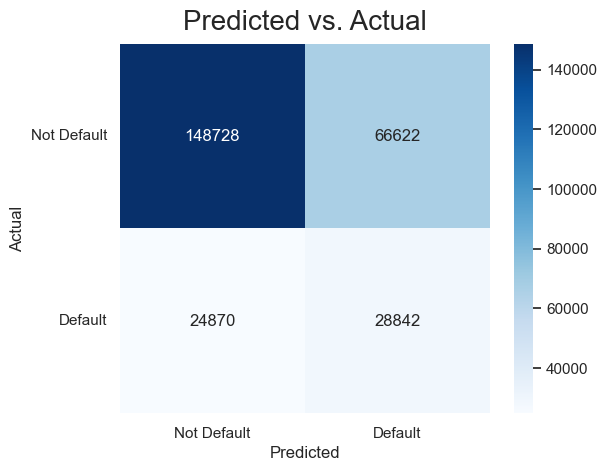

In [55]:
# Generate confusion matrix for random forest model on test dataset
make_confusion_matrix_test(X_test,rndforest, threshold=0.210526)

9.24 10.72 19.96


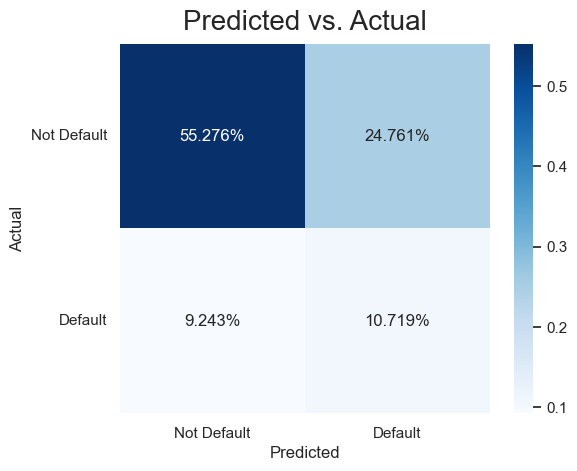

In [56]:
# Generate confusion matrix for random forest model on test dataset
make_confusion_matrix_test(X_test,rndforest, info='perc', threshold=0.210526)

### Confusion Matrix for XGBoost 

0.08646334302131108 0.11316350878236243 0.1996268518036735


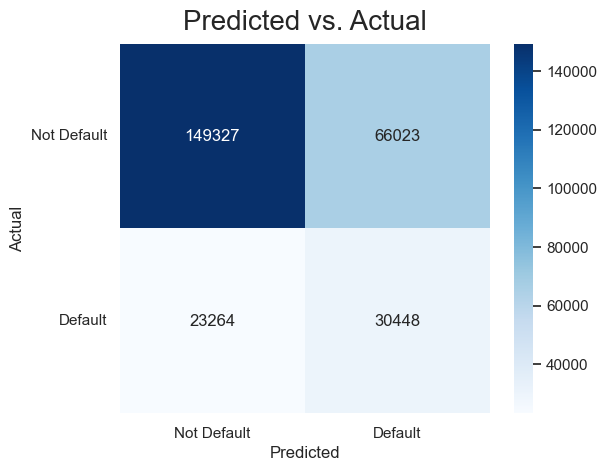

In [57]:
# Create a confusion matrix 
make_confusion_matrix_val(X_val,xgb_classifier, threshold=0.210526)

8.61 11.36 19.96


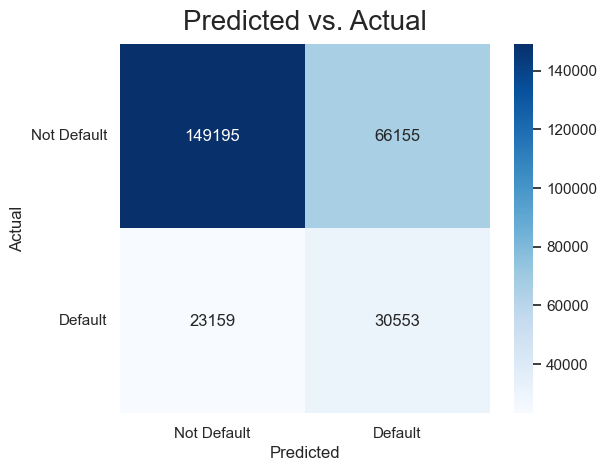

In [58]:
make_confusion_matrix_test(X_test,xgb_classifier, threshold=0.210526)

8.61 11.36 19.96


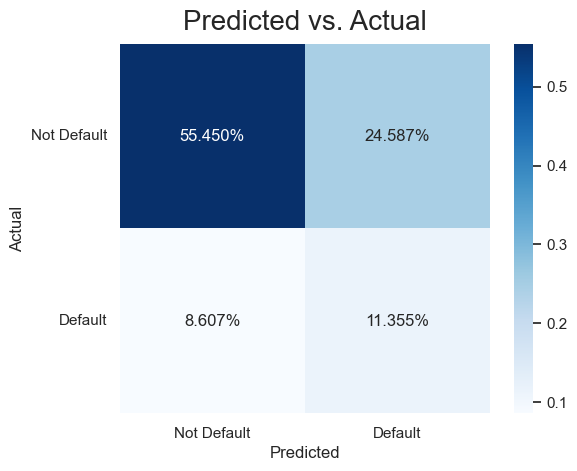

In [59]:
make_confusion_matrix_test(X_test,xgb_classifier,info='perc', threshold=0.210526)

### Confusion Matrix for Gradient Boosting

0.08732931443310464 0.11229753737056887 0.1996268518036735


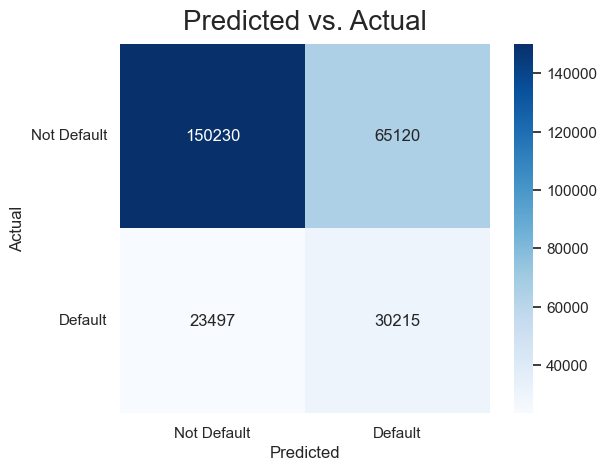

In [60]:
# Create a confusion matrix 
make_confusion_matrix_val(X_val,gbc, threshold=0.210526)

8.69 11.27 19.96


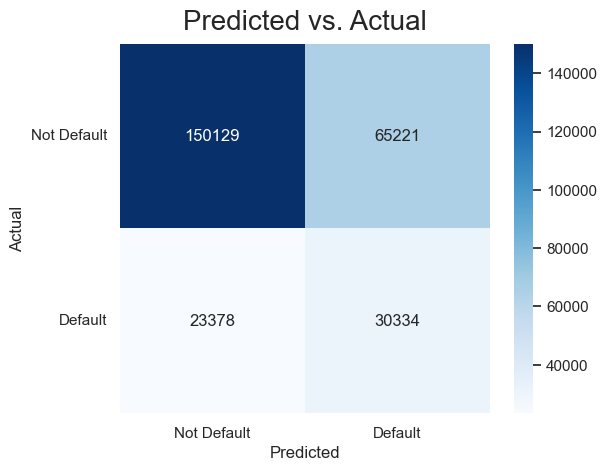

In [61]:
# Generate confusion matrix 
make_confusion_matrix_test(X_test,gbc, threshold=0.210526)


8.69 11.27 19.96


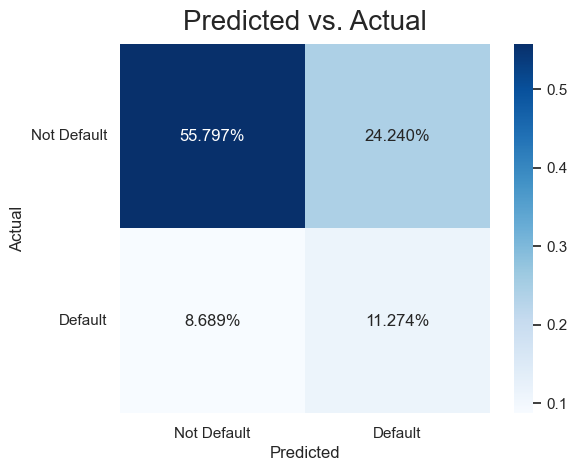

In [62]:
# Generate confusion matrix 
make_confusion_matrix_test(X_test,gbc, info='perc',threshold=0.210526)


8.92 11.05 19.96


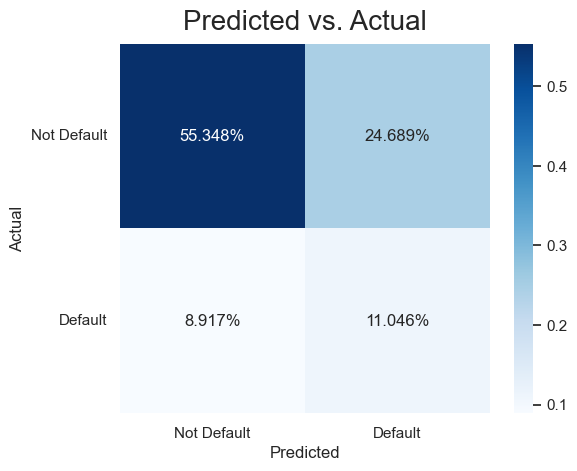

In [63]:
# Generate confusion matrix 
make_confusion_matrix_test(X_test,logreg, info='perc',threshold=0.210526)


## Choose the Best Model

In [65]:
best_model = xgb_classifier ## this works.
# best_model = gbc ## this works.

## Adding results to Train, Val and Test dataframe

In [67]:
X_train.head()

,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT,target
id,,,,,,,,,,,,,,
105253408,0.179897,-0.564595,2.890743e-01,0.119112,0.231563,0.410550,2.617179,-0.612346,-1.188047,1,0,0,0,1
16592425,0.546808,1.771181,-4.961623e-16,-0.183949,-0.964507,0.069240,-1.046193,0.647717,1.963179,0,0,1,0,0
58470345,-0.966701,-0.564595,2.890743e-01,-0.637249,0.967607,-1.046003,-0.679856,-0.678630,-1.188047,0,0,0,1,0
10092824,-0.508062,-0.564595,2.890743e-01,1.013113,-0.596485,-0.662140,0.785493,7.479771,5.789667,1,0,0,0,0
65965690,0.753196,-0.564595,1.127018e+00,0.930595,-2.068572,0.227040,-0.130350,0.558540,-0.287696,1,0,0,0,1


In [68]:
# Train
Train = X_train.copy()
Train['y_pred'] = best_model.predict(X_train.drop(columns='target'))
Train['y_score'] = best_model.predict_proba(X_train.drop(columns='target'))[:,1]

# Validation
Val = X_val.copy()
Val['y_pred'] = best_model.predict(X_val.drop(columns='target'))
Val['y_score'] = best_model.predict_proba(X_val.drop(columns='target'))[:,1]

# Test
Test = X_test.copy()
Test['y_pred'] = best_model.predict(X_test.drop(columns='target'))
Test['y_score'] = best_model.predict_proba(X_test.drop(columns='target'))[:,1]


## Saving Train, Val and Test datraframe with results.

In [69]:
def save_final_dataset(Train, Val, Test):
    Train.to_csv('../input/Train_after_modeling.csv', sep=',', encoding='utf-8',index=True)
    Val.to_csv('../input/Val_after_modeling.csv', sep=',', encoding='utf-8',index=True)
    Test.to_csv('../input/Test_after_modeling.csv', sep=',', encoding='utf-8',index=True)

save_final_dataset(Train, Val, Test)

## STOP HERE!!

## Explain ML Model

#### Feature Importance

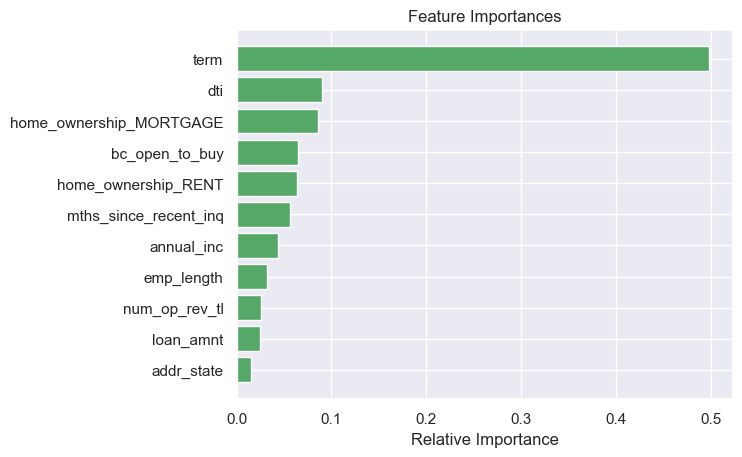

In [ ]:
importances = best_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns.tolist()
plt.title('Feature Importances')
j = 11 # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
#plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

### Shap Importance

In [ ]:
import shap

In [ ]:
# compute SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

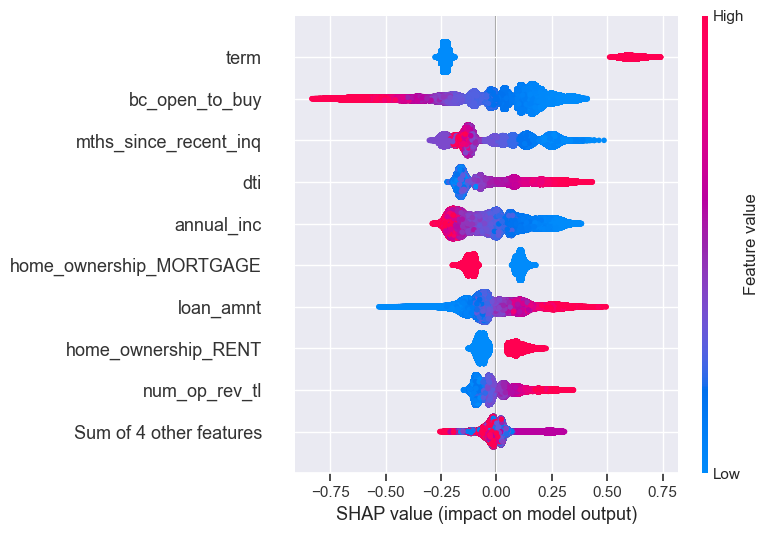

2024-02-26 17:10:42.179 
  command:

    streamlit run /Users/rafaelr/MyProjects/loan_bank_model_project_v1/env_loan_bank/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [ ]:
import streamlit as st
from streamlit_shap import st_shap

# compute SHAP values
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)

st_shap(shap.plots.beeswarm(shap_values), height=300)

## Para um individuo apenas!!

In [ ]:
X_train.head(2)

,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT
id,,,,,,,,,,,,,
105253408,0.179897,-0.564595,0.289061,0.119112,0.231563,0.41055,2.617142,-0.612313,-1.188055,1,0,0,0
16592425,0.546808,1.771181,0.000214,-0.183949,-0.964507,0.06924,-1.046230,0.647751,1.963171,0,0,1,0


In [ ]:
df00_not_norm.loc[16592425]

loan_amnt                  19200.000000
term                           2.000000
emp_length                     5.965873
annual_inc                 62960.000000
addr_state                    30.000000
dti                           19.060000
mths_since_recent_inq          1.000000
bc_open_to_buy             19930.000000
num_op_rev_tl                 17.000000
home_ownership_MORTGAGE        0.000000
home_ownership_OTHERS          0.000000
home_ownership_OWN             1.000000
home_ownership_RENT            0.000000
target                         0.000000
Name: 16592425, dtype: float64

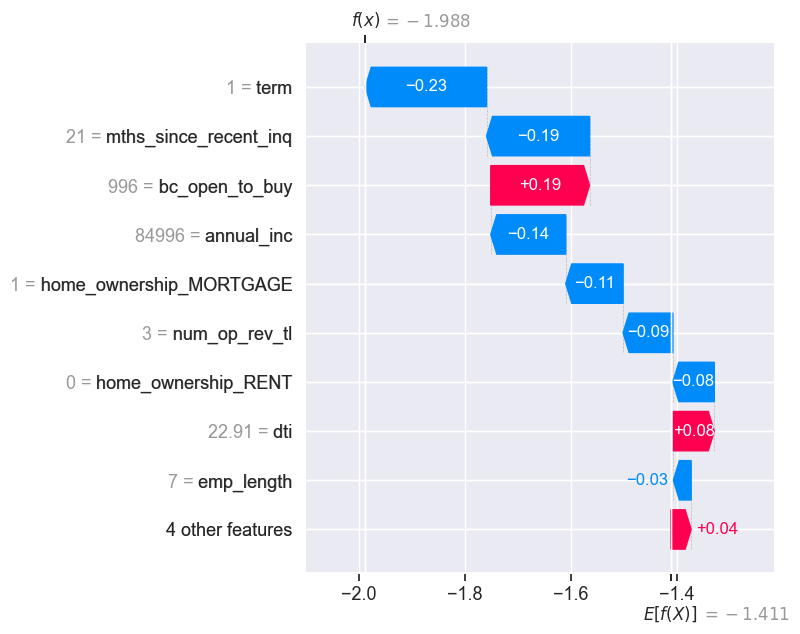

DeltaGenerator()

In [ ]:
# Calcular os valores SHAP para uma única instância
# instance_index = 0  # Índice da instância que você deseja explicar
id = 105253408
# shap_values_instance = explainer(np.expand_dims(X_train.values[instance_index], axis=0))
shap_values_instance = explainer(np.expand_dims(X_train.loc[id].values, axis=0))

# Criar um objeto Explanation que inclui os nomes das features
explanation = shap.Explanation(
    values=shap_values_instance.values[0],  # Valores SHAP para a instância
    base_values=shap_values_instance.base_values[0],  # Valor base
    # data=X_train.iloc[instance_index],  # Dados da instância
    data=df00_not_norm.loc[id],
    feature_names=X_train.columns  # Nomes das features
)

# Gerar e exibir o gráfico de cascata com os nomes das features
st_shap(shap.plots.waterfall(explanation), height=300)

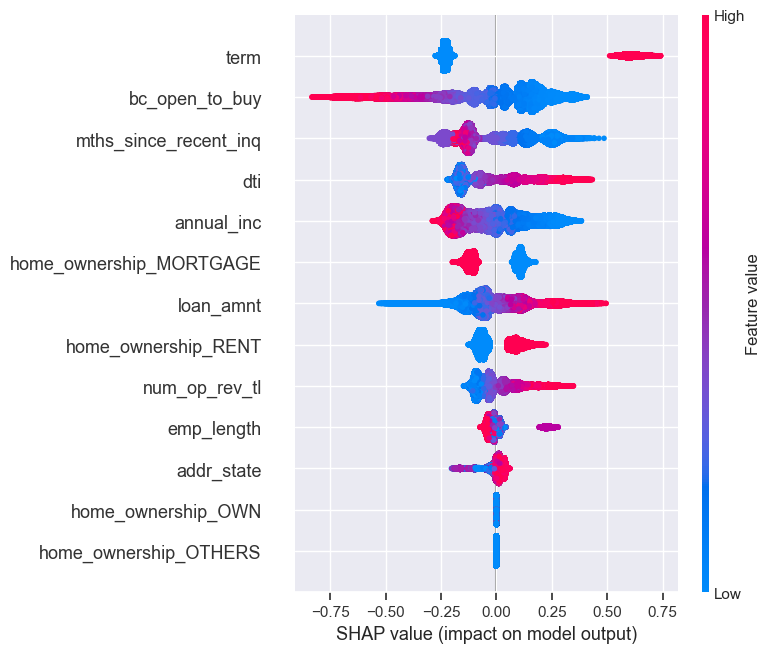

In [ ]:
shap.summary_plot(shap_values, X_train.values, feature_names = X_train.columns)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((807186, 13), (807186,), (269062, 13), (269062,), (269062, 13), (269062,))

In [ ]:
# compute SHAP values
explainer_t = shap.TreeExplainer(best_model)
shap_values_t = explainer.shap_values(X_test)

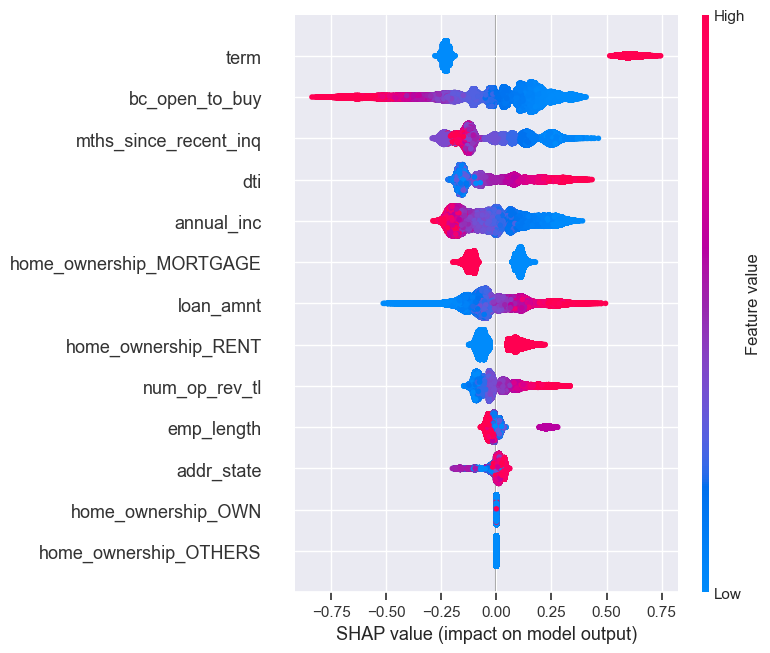

In [ ]:
shap.summary_plot(shap_values_t, X_test.values, feature_names = X_test.columns)

### Selecting features
- loan_amnt - The listed amount of the loan applied by the borrower.
- term - The number of payments on the loan, where values are in months and can be either 36 or 60.
- int_rate - The interest rate on the loan
- sub_grade - Assigned loan subgrade score based on borrower's credit history
- emp_length - Borrow's employment length in years.
- home_ownership - The homeownership status provided by the borrower (eg rent, own, mortgage, etc)
- annual_inc - The self-reported annual income provided by the borrower
- addr_state - The state provided by the borrower in the loan application
- dti - A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage, divided by the borrower’s monthly income.
- mths_since_recent_inq - Months since most recent inquiry
- revol_util - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- bc_open_to_buy - Total open to buy on revolving bankcards
- bc_util - Ratio of total current balance to high credit/credit limit for all bankcard accounts
- num_op_rev_tl - Number of open revolving accounts
- loan_status - Current status of the loan (eg fully paid or charged off), this is the label we are going to predict with the model.

### Explain Features and yours values.
- loan with 60 months have higher probability to have Charge Off status in future.
- For lower values on bc_open_to_buy, mths_since_recent_inq and annual_inc have more probability of Charge Off status in future.
- For higher values on dti, loan_amount and num_op_rev_tl there are higher probability of Charge Off status in future.
- There are higher probability of Charge Off status for Borrowers dont have Mortage or have Rent status.  


In [ ]:
## stop here!!

## Policy Function

In [5]:
def FaixasDecil(dataframe,scorename,targetname):
    import pandas as pd
    import numpy as np 
    
    dataframe['good'] = 1 - dataframe[targetname]
    dataframe['bucket'] = pd.qcut(dataframe[scorename], 10,duplicates='drop')
    grouped = dataframe.groupby('bucket', as_index = False)
    agg1 = grouped.min()[scorename].values
    agg1 = pd.DataFrame(data=agg1, columns = ['min_scr'])
    
    agg1['max_scr'] = grouped.max()[scorename]
    
    agg1['bads'] = grouped.sum()[targetname]
    agg1['goods'] = grouped.sum().good
    agg1['total'] = agg1.bads + agg1.goods
    
    # agg2 = (agg1.sort_index(by = 'min_scr')).reset_index(drop = True)
    agg2 = (agg1.sort_values(by = 'min_scr')).reset_index(drop = True)
    agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
    agg2['bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
    agg2['ks'] = np.round((-(agg2.bads / dataframe[targetname].sum()).cumsum() + (agg2.goods / dataframe.good.sum()).cumsum()), 4) * 100
    # agg2['ks'] = np.round((-(agg2.bads).cumsum() + (agg2.goods).cumsum()), 4) * 100
    flag = lambda x: '<== KS ==' if x == agg2.ks.max() else ''
    agg2['max_ks'] = agg2.ks.apply(flag)
    ks_valor = round(agg2.sort_values(by='ks', ascending=False)['ks'].iloc[0],2)
    
    return agg2, ks_valor

In [6]:
def FaixasCentil(dataframe,scorename,targetname,num=10000):
    import pandas as pd
    import numpy as np 
    data_bad = dataframe[targetname].copy()
    dataframe['good'] = 1 - dataframe[targetname]
    data_good = dataframe['good'].copy()
    dataframe['bucket'] = pd.qcut(dataframe[scorename], 100,duplicates='drop')
    grouped = dataframe.groupby('bucket', as_index = False)
    agg1 = grouped.min()[scorename].values
    agg1 = pd.DataFrame(data=agg1, columns = ['min_scr'])
    
    agg1['max_scr'] = grouped.max()[scorename]
    
    agg1['bads'] = grouped.sum()[targetname]
    agg1['goods'] = grouped.sum().good
    agg1['total'] = agg1.bads + agg1.goods
    
    # agg2 = (agg1.sort_index(by = 'min_scr')).reset_index(drop = True)
    agg2 = (agg1.sort_values(by = 'min_scr')).reset_index(drop = True)
    agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
    agg2['perc_bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
    agg2['bad_rate'] = (agg2.bads / agg2.total)*100

    agg2['ks'] = np.round((-(agg2.bads / data_bad.sum()).cumsum() + (agg2.goods / data_good.sum()).cumsum()), 4) * 100
    # agg2['ks'] = np.round((-(agg2.bads).cumsum() + (agg2.goods).cumsum()), 4) * 100
    flag = lambda x: '<== KS ==' if x == agg2.ks.max() else ''
    agg2['max_ks'] = agg2.ks.apply(flag)
    ks_valor = round(agg2.sort_values(by='ks', ascending=False)['ks'].iloc[0],2)
    agg2['min_scr'] = agg2['min_scr'].mul(num)
    agg2['max_scr'] = agg2['max_scr'].mul(num)
    
    return agg2, ks_valor

In [7]:
agg, ks_valor = FaixasDecil(X_test,'y_score','target')

In [8]:
display(agg)
print(agg.to_csv(lineterminator='\r\n'))

,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.028926,0.094808,1618,25289,26907,15.63,6.01%,8.73,
1,0.094808,0.117723,2538,24368,26906,9.60,9.43%,15.32,
2,0.117723,0.137063,3143,23763,26906,7.56,11.68%,20.50,
3,0.137063,0.155926,3875,23031,26906,5.94,14.40%,23.98,
4,0.155927,0.176281,4542,22364,26906,4.92,16.88%,25.91,
5,0.176282,0.199667,5133,21773,26906,4.24,19.08%,26.47,<== KS ==
6,0.199668,0.229040,5851,21055,26906,3.60,21.75%,25.35,
7,0.229041,0.270854,6971,19935,26906,2.86,25.91%,21.63,
8,0.270854,0.341179,8396,18510,26906,2.20,31.20%,14.59,
9,0.341188,0.743589,11645,15262,26907,1.31,43.28%,0.00,


,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.028926235,0.09480802,1618,25289,26907,15.63,6.01%,8.73,
1,0.09480808,0.1177229,2538,24368,26906,9.60,9.43%,15.32,
2,0.11772298,0.13706318,3143,23763,26906,7.56,11.68%,20.5,
3,0.13706324,0.15592581,3875,23031,26906,5.94,14.40%,23.98,
4,0.15592691,0.17628086,4542,22364,26906,4.92,16.88%,25.91,
5,0.17628159,0.19966696,5133,21773,26906,4.24,19.08%,26.47,<== KS ==
6,0.19966799,0.2290399,5851,21055,26906,3.60,21.75%,25.35,
7,0.22904074,0.27085423,6971,19935,26906,2.86,25.91%,21.63,
8,0.2708543,0.34117922,8396,18510,26906,2.20,31.20%,14.59,
9,0.34118822,0.7435888,11645,15262,26907,1.31,43.28%,0.0,



In [9]:
display(agg)
print(agg.to_csv(lineterminator='\r\n'))

,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.028926,0.094808,1618,25289,26907,15.63,6.01%,8.73,
1,0.094808,0.117723,2538,24368,26906,9.60,9.43%,15.32,
2,0.117723,0.137063,3143,23763,26906,7.56,11.68%,20.50,
3,0.137063,0.155926,3875,23031,26906,5.94,14.40%,23.98,
4,0.155927,0.176281,4542,22364,26906,4.92,16.88%,25.91,
5,0.176282,0.199667,5133,21773,26906,4.24,19.08%,26.47,<== KS ==
6,0.199668,0.229040,5851,21055,26906,3.60,21.75%,25.35,
7,0.229041,0.270854,6971,19935,26906,2.86,25.91%,21.63,
8,0.270854,0.341179,8396,18510,26906,2.20,31.20%,14.59,
9,0.341188,0.743589,11645,15262,26907,1.31,43.28%,0.00,


,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.028926235,0.09480802,1618,25289,26907,15.63,6.01%,8.73,
1,0.09480808,0.1177229,2538,24368,26906,9.60,9.43%,15.32,
2,0.11772298,0.13706318,3143,23763,26906,7.56,11.68%,20.5,
3,0.13706324,0.15592581,3875,23031,26906,5.94,14.40%,23.98,
4,0.15592691,0.17628086,4542,22364,26906,4.92,16.88%,25.91,
5,0.17628159,0.19966696,5133,21773,26906,4.24,19.08%,26.47,<== KS ==
6,0.19966799,0.2290399,5851,21055,26906,3.60,21.75%,25.35,
7,0.22904074,0.27085423,6971,19935,26906,2.86,25.91%,21.63,
8,0.2708543,0.34117922,8396,18510,26906,2.20,31.20%,14.59,
9,0.34118822,0.7435888,11645,15262,26907,1.31,43.28%,0.0,



In [10]:
agg2, ks_valor = FaixasCentil(X_test,'y_score','target',num=1)

In [11]:
display(agg2.tail(10))
print(agg2.tail(10).to_csv(lineterminator='\r\n'))


,min_scr,max_scr,bads,goods,total,odds,perc_bad_rate,bad_rate,ks,max_ks
90,0.341188,0.351477,994,1697,2691,1.71,36.94%,36.937941,13.53,
91,0.351486,0.362823,1013,1678,2691,1.66,37.64%,37.643999,12.42,
92,0.362825,0.375279,1021,1669,2690,1.63,37.96%,37.955390,11.30,
93,0.375279,0.389213,1075,1616,2691,1.50,39.95%,39.947975,10.05,
94,0.389215,0.404433,1100,1590,2690,1.45,40.89%,40.892193,8.74,
95,0.404448,0.422405,1113,1578,2691,1.42,41.36%,41.360089,7.40,
96,0.422409,0.444262,1198,1493,2691,1.25,44.52%,44.518766,5.86,
97,0.444275,0.472815,1271,1419,2690,1.12,47.25%,47.249071,4.15,
98,0.472830,0.513574,1363,1328,2691,0.97,50.65%,50.650316,2.23,
99,0.513575,0.743589,1497,1194,2691,0.80,55.63%,55.629877,0.00,


,min_scr,max_scr,bads,goods,total,odds,perc_bad_rate,bad_rate,ks,max_ks
90,0.34118822,0.35147706,994,1697,2691,1.71,36.94%,36.93794128576737,13.530000000000001,
91,0.35148552,0.36282337,1013,1678,2691,1.66,37.64%,37.64399851356373,12.42,
92,0.36282492,0.37527907,1021,1669,2690,1.63,37.96%,37.95539033457249,11.3,
93,0.3752792,0.38921314,1075,1616,2691,1.50,39.95%,39.947974730583425,10.05,
94,0.38921517,0.40443304,1100,1590,2690,1.45,40.89%,40.89219330855018,8.74,
95,0.40444803,0.4224045,1113,1578,2691,1.42,41.36%,41.36008918617614,7.3999999999999995,
96,0.42240855,0.44426218,1198,1493,2691,1.25,44.52%,44.518766257896694,5.86,
97,0.4442745,0.47281504,1271,1419,2690,1.12,47.25%,47.249070631970255,4.15,
98,0.4728299,0.5135739,1363,1328,2691,0.97,50.65%,50.65031586770717,2.23,
99,0.5135745,0.7435888,1497,1194,2691,0.80,55.63%,55.62987736900781,0.0,



In [12]:
pd.set_option('display.max_rows', 500)
display(agg2)
# print(agg2.to_csv(lineterminator='\r\n'))


,min_scr,max_scr,bads,goods,total,odds,perc_bad_rate,bad_rate,ks,max_ks
0,0.028926,0.055504,70,2621,2691,37.44,2.60%,2.601263,1.09,
1,0.055508,0.064034,87,2604,2691,29.93,3.23%,3.232999,2.13,
2,0.064034,0.070070,132,2558,2690,19.38,4.91%,4.907063,3.08,
3,0.070070,0.074758,154,2537,2691,16.47,5.72%,5.722780,3.97,
4,0.074759,0.078820,168,2523,2691,15.02,6.24%,6.243032,4.83,
5,0.078826,0.082595,181,2509,2690,13.86,6.73%,6.728625,5.65,
6,0.082596,0.086047,186,2505,2691,13.47,6.91%,6.911929,6.47,
7,0.086050,0.089116,191,2499,2690,13.08,7.10%,7.100372,7.28,
8,0.089122,0.092001,213,2478,2691,11.63,7.92%,7.915273,8.03,
9,0.092001,0.094808,236,2455,2691,10.40,8.77%,8.769974,8.73,


## Setting the Risk Ranges

In [13]:
num=1000
## 4 bands 0.188781, 0.293090, 0.392873
bins=[0, 0.212030, 0.293090, 0.392873, 1.0]
labels=['Very Low','Low','Medium High','High']


agg2['Propensity_Class'] = pd.cut(agg2.max_scr, bins=bins, 
                        labels=labels,
       include_lowest=True,
       right=True)

grouped = agg2.groupby('Propensity_Class', as_index = False)
agg3 = pd.DataFrame()
agg3['min_scr'] = grouped.min()['min_scr']
agg3['max_scr'] = grouped.max()['max_scr']

agg3['bads'] = grouped.sum()['bads']
agg3['goods'] = grouped.sum()['goods']
agg3['total'] = agg3.bads + agg3.goods


agg3['perc_bad_rate'] = (agg3.bads / agg3.total).apply('{0:.1%}'.format)
agg3['bad_rate'] = (agg3.bads / agg3.total)*100

agg3['perc_bads'] = (agg3.bads / agg2.bads.sum()).apply('{0:.1%}'.format)
agg3['pbads'] = (agg3.bads / agg2.bads.sum())*100

agg3['perc_goods'] = (agg3.goods / agg2.goods.sum()).apply('{0:.1%}'.format)
agg3['pgoods'] = (agg3.goods / agg2.goods.sum())*100

agg3['perc_propensity'] = (agg3.bads / agg2.total.sum()).apply('{0:.2%}'.format)
agg3['ppropensity'] = (agg3.bads / agg2.total.sum())*100

agg3['perc_population'] = (agg3.total / agg2.total.sum()).apply('{0:.0%}'.format)
agg3['ppopulation'] = (agg3.total / agg2.total.sum())*100

agg3['Propensity Bands'] = labels
# agg3['min_scr'].iloc[0] = 0
agg3_shift = agg3['max_scr'].shift()
agg3_shift.iloc[0]=0
agg3['min_scr'] = agg3_shift
agg3['max_scr'].iloc[-1] = 1
agg3['Score Ranges'] = (agg3['min_scr'].mul(num)).round(4).astype(str) + ' a ' + agg3['max_scr'].mul(num).round(4).astype(str)


_prop_pol = agg3[['Propensity Bands','Score Ranges','perc_population','perc_bads','perc_goods','perc_propensity']]
prop_pol = _prop_pol.rename(columns={
                          'Propensity Bands':'Risk Bands',
                     #      'Score Ranges':'Faixas de Score', 
                          'perc_population':'% of Population', 
                          'perc_bads':'% Bads', 
                          'perc_goods':'% Goods', 
                          'perc_propensity':'% Risk'})

prop_pol.to_csv('../artifacts/prop_pol.csv')                          
prop_pol.head()
    

,Risk Bands,Score Ranges,% of Population,% Bads,% Goods,% Risk
0,Very Low,0.0 a 210.3668,64%,43.1%,69.2%,8.60%
1,Low,210.3668 a 287.422,19%,23.9%,17.8%,4.78%
2,Medium High,287.422 a 389.2131,11%,19.0%,9.0%,3.78%
3,High,389.2131 a 1000.0,6%,14.0%,4.0%,2.80%


## Medium and High Risk Ranges split 16% of the population and indicate 31% of Bad Borrowers against 12% of Good Borrowers.
- It means that scores higher than 0.2931 have to be use as threshold to indicate Borrowers that will charge off in the future.

## Recomendation by Risk Bands

In [14]:
_bins = agg3.min_scr.tolist()
_bins.append(1)

In [15]:
_bins

[0.0, 0.21036679, 0.287422, 0.38921314, 1]

In [16]:
labels = prop_pol['Risk Bands'].tolist()
labels

['Very Low', 'Low', 'Medium High', 'High']

In [17]:
# Define bins (limits) to categorizaton
bins = _bins

# Define labels of categs
labels = labels


In [18]:
_bins

[0.0, 0.21036679, 0.287422, 0.38921314, 1]

In [19]:
# Create Propensity Bands on Test dataset
X_test['Risk Bands'] = pd.cut(X_test['y_score'], bins=_bins, labels=labels, right=False)


In [20]:
X_test['Risk Bands'].value_counts()

Risk Bands
Very Low       172199
Low             51121
Medium High     29597
High            16145
Name: count, dtype: int64

In [21]:
X_test.columns

Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'addr_state', 'dti',
       'mths_since_recent_inq', 'bc_open_to_buy', 'num_op_rev_tl',
       'home_ownership_MORTGAGE', 'home_ownership_OTHERS',
       'home_ownership_OWN', 'home_ownership_RENT', 'target', 'y_pred',
       'y_score', 'good', 'bucket', 'Risk Bands'],
      dtype='object')

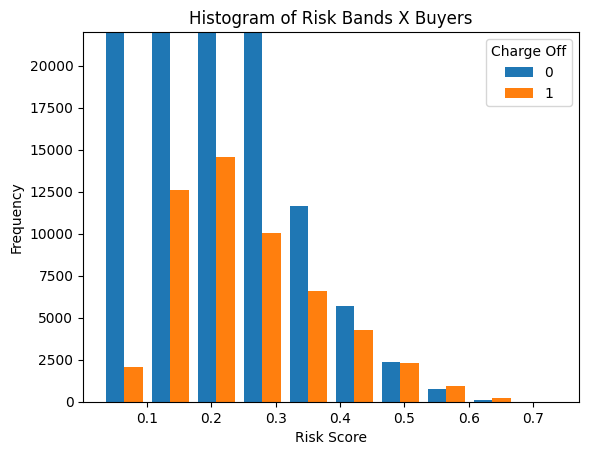

In [22]:
import matplotlib.pyplot as plt

# group data
grouped_data = X_test.groupby('target')['y_score']

# Histogram 1
# plt.hist([grouped_data.get_group(key) for key in grouped_data.groups.keys()], bins=5, alpha=0.5, label=grouped_data.groups.keys())
plt.hist([grouped_data.get_group(key) for key in grouped_data.groups.keys()], bins=10, alpha=1, label=[0,1])

# title
plt.title('Histogram of Risk Bands X Buyers')

# axis
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.ylim(0,22000)
# legend
plt.legend(title='Charge Off')

# show
plt.show()


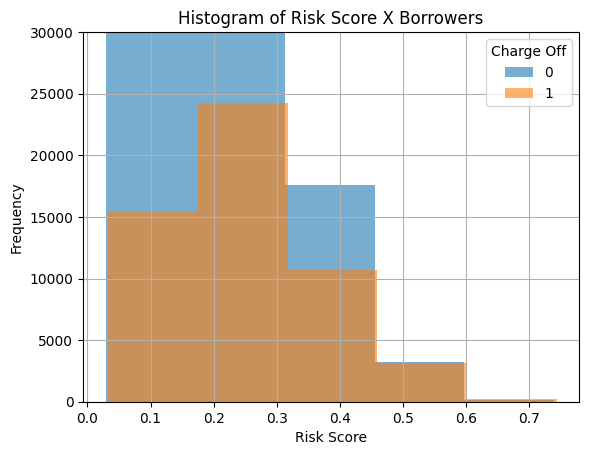

In [23]:
## Histogram 2
X_test.groupby('target')['y_score'].hist(bins=5,alpha=0.6) 
plt.title('Histogram of Risk Score X Borrowers')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.ylim(0,30000)
plt.legend(labels=[0,1],title='Charge Off')
plt.show()

In [24]:
prop_pol

,Risk Bands,Score Ranges,% of Population,% Bads,% Goods,% Risk
0,Very Low,0.0 a 210.3668,64%,43.1%,69.2%,8.60%
1,Low,210.3668 a 287.422,19%,23.9%,17.8%,4.78%
2,Medium High,287.422 a 389.2131,11%,19.0%,9.0%,3.78%
3,High,389.2131 a 1000.0,6%,14.0%,4.0%,2.80%


## Define and Apply Thresold to Decision

In [25]:
# Define recomendation
X_test['Risk_Recomendation'] = X_test['Risk Bands'].apply(lambda x: 1 if x in ["Medium High", "High"] else 0)

# Verify
X_test['Risk_Recomendation'].value_counts()



Risk_Recomendation
0    223320
1     45742
Name: count, dtype: int64

## Save threshold for decision

In [26]:
import joblib

threshold_medium_risk_decision = X_test[X_test['Risk Bands']=="Medium High"]['y_score'].min()
joblib.dump(threshold_medium_risk_decision, "../artifacts/threshold_medium_risk_decision.joblib")

threshold_high_risk_decision = X_test[X_test['Risk Bands']=="High"]['y_score'].min()
joblib.dump(threshold_high_risk_decision, "../artifacts/threshold_high_risk_decision.joblib")


['../artifacts/threshold_high_risk_decision.joblib']

In [27]:
threshold_medium_risk_decision, threshold_high_risk_decision

(0.287422, 0.38921314)

In [28]:
prop_pol

,Risk Bands,Score Ranges,% of Population,% Bads,% Goods,% Risk
0,Very Low,0.0 a 210.3668,64%,43.1%,69.2%,8.60%
1,Low,210.3668 a 287.422,19%,23.9%,17.8%,4.78%
2,Medium High,287.422 a 389.2131,11%,19.0%,9.0%,3.78%
3,High,389.2131 a 1000.0,6%,14.0%,4.0%,2.80%


## Run streamlit.py process

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
import shap

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb


In [49]:
# df00 = pd.read_csv('input/df.csv')
df00 = pd.read_csv('input/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')


In [86]:
import joblib
metadata = pd.read_csv('artifacts/metadata.csv')

mean_vars_num = joblib.load('artifacts/mean_vars_num.joblib')
loaded_scaler = joblib.load('artifacts/scaler.joblib')
map_addr_state = joblib.load('artifacts/map_addr_state.joblib')

# features_used_to_train
features_used_to_train = joblib.load('artifacts/features_used_to_train.joblib')

map_addr_state


{'IA': 1,
 nan: 2,
 'ND': 3,
 'ID': 4,
 'SD': 5,
 'WY': 6,
 'VT': 7,
 'ME': 8,
 'AK': 9,
 'DC': 10,
 'MT': 11,
 'DE': 12,
 'NE': 13,
 'WV': 14,
 'RI': 15,
 'HI': 16,
 'NH': 17,
 'NM': 18,
 'MS': 19,
 'UT': 20,
 'AR': 21,
 'KS': 22,
 'OK': 23,
 'KY': 24,
 'LA': 25,
 'OR': 26,
 'AL': 27,
 'SC': 28,
 'WI': 29,
 'NV': 30,
 'TN': 31,
 'CT': 32,
 'MO': 33,
 'IN': 34,
 'MN': 35,
 'WA': 36,
 'CO': 37,
 'MA': 38,
 'AZ': 39,
 'MD': 40,
 'MI': 41,
 'NC': 42,
 'VA': 43,
 'GA': 44,
 'OH': 45,
 'PA': 46,
 'NJ': 47,
 'IL': 48,
 'FL': 49,
 'TX': 50,
 'NY': 51,
 'CA': 52}

In [116]:
print(map_addr_state.keys())

dict_keys(['IA', nan, 'ND', 'ID', 'SD', 'WY', 'VT', 'ME', 'AK', 'DC', 'MT', 'DE', 'NE', 'WV', 'RI', 'HI', 'NH', 'NM', 'MS', 'UT', 'AR', 'KS', 'OK', 'KY', 'LA', 'OR', 'AL', 'SC', 'WI', 'NV', 'TN', 'CT', 'MO', 'IN', 'MN', 'WA', 'CO', 'MA', 'AZ', 'MD', 'MI', 'NC', 'VA', 'GA', 'OH', 'PA', 'NJ', 'IL', 'FL', 'TX', 'NY', 'CA'])


In [82]:
input_user = df00[df00['id']==93952372]
select_cols = ['id',
 'loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'addr_state',
 'dti',
 'mths_since_recent_inq',
 'bc_open_to_buy',
 'num_op_rev_tl',
 'loan_status']

input_user = input_user[select_cols].head(1)
input_user.head().T

,2200605
id,93952372
loan_amnt,15000.0
term,36 months
emp_length,10+ years
home_ownership,OWN
annual_inc,70000.0
addr_state,TX
dti,21.12
mths_since_recent_inq,11.0
bc_open_to_buy,4101.0


In [105]:
loan_amnt = input_user['loan_amnt'].values[0]
term = input_user['term'].values[0]
# sub_grade = input_user['sub_grade'].values[0]
home_ownership = input_user['home_ownership'].values[0]
emp_length = input_user['emp_length'].values[0]
annual_inc = input_user['annual_inc'].values[0]
dti = input_user['dti'].values[0]
mths_since_recent_inq = input_user['mths_since_recent_inq'].values[0]
# revol_util = input_user['revol_util'].values[0]
addr_state = input_user['addr_state'].values[0]
bc_open_to_buy = input_user['bc_open_to_buy'].values[0]
num_op_rev_tl = input_user['num_op_rev_tl'].values[0]

In [106]:
bc_open_to_buy

4101.0

In [108]:
def preprocess(loan_amnt, term, 
            #    sub_grade, 
            home_ownership,
               emp_length, annual_inc, dti, mths_since_recent_inq, 
            #    revol_util, 
            addr_state, bc_open_to_buy,
               num_op_rev_tl):
    # Pre-processing user input

    user_input_dict={'loan_amnt':[loan_amnt], 'term':[term],
                    #   'sub_grade':[sub_grade], 
                      'home_ownership':[home_ownership], 
                      'emp_length':[emp_length], 'annual_inc':[annual_inc], 'dti':[dti],
                'mths_since_recent_inq':[mths_since_recent_inq], 
                # 'revol_util':[revol_util], 
                'addr_state':[addr_state],
                'bc_open_to_buy':[bc_open_to_buy],
                'num_op_rev_tl':[num_op_rev_tl]}
    user_input=pd.DataFrame(data=user_input_dict)
    display(user_input)


    #user_input=np.array(user_input)
    #user_input=user_input.reshape(1,-1)

    cleaner_type = {"term": {" 36 months": 1.0, " 60 months": 2.0},
    "addr_state": map_addr_state,
    "emp_length": {"< 1 year": 0.0, '1 year': 1.0, '2 years': 2.0, '3 years': 3.0, '4 years': 4.0,
    '5 years': 5.0, '6 years': 6.0, '7 years': 7.0, '8 years': 8.0, '9 years': 9.0,
    '10+ years': 10.0 }
    }

    user_input = user_input.replace(cleaner_type)

    user_input.home_ownership.replace({"ANY":"OTHERS","OTHER":"OTHERS","NONE":"OTHERS"},inplace=True)
    user_input = pd.get_dummies(user_input, 
                      columns=['home_ownership'],
                      drop_first=False, 
                      prefix ='home_ownership',
                      prefix_sep='_',
                      dtype=int)

    # Indicate all columns used to train 
    l1 = user_input.columns.tolist()
    l2 = features_used_to_train
 
    columns_to_add = list(set(l2)-set(l1))
    # Adicionando as novas colunas com valores padrão NaN
    for col in columns_to_add:
       user_input[col] = 0
 
    user_input = user_input[l2]


    # Normalization 
    # Selecting Numeric Features
    lista_vars_numericas = list(
      metadata[((metadata.Level  == 'ordinal')|(metadata.Level == 'interval')) & (metadata.Role == 'input')]
      ['Features'])

    user_input[lista_vars_numericas] = (user_input[lista_vars_numericas].fillna(mean_vars_num)
         ).astype(float)

    ## Standarlization

    # Use the loaded scaler to transform the new data
    scaled_features_new = loaded_scaler.transform(user_input[lista_vars_numericas])
    user_input[lista_vars_numericas] = scaled_features_new


    return user_input

#user_input=preprocess
user_input=preprocess(loan_amnt, term, home_ownership, emp_length, annual_inc, dti, mths_since_recent_inq,addr_state, bc_open_to_buy, num_op_rev_tl)
user_input.head()


,loan_amnt,term,home_ownership,emp_length,annual_inc,dti,mths_since_recent_inq,addr_state,bc_open_to_buy,num_op_rev_tl
0,15000.0,36 months,OWN,10+ years,70000.0,21.12,11.0,TX,4101.0,14.0


,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT
0,0.065237,-0.564595,1.127005,-0.087128,0.875601,0.251863,0.785456,-0.405674,1.287908,0,0,1,0


In [109]:
#prepare test set for shap explainability

model=joblib.load("artifacts/best_model.joblib")

loans = pd.read_csv("input/Test.csv")
X = loans.drop(columns=['target'])
y = loans[['target']]
y_ravel = y.values.ravel()

X.head(2)

,id,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT
0,93952372,0.065237,-0.564595,1.127005,-0.087128,0.875601,0.251863,0.785456,-0.405674,1.287908,0,0,1,0
1,15741465,1.211835,-0.564595,1.127005,-0.224658,-0.504480,0.778456,0.052781,-0.605990,2.188259,1,0,0,0


In [110]:
pd.concat([user_input.head(),
X[user_input.columns.tolist()].head(1)]).T

,0,0
loan_amnt,0.065237,0.065237
term,-0.564595,-0.564595
emp_length,1.127005,1.127005
annual_inc,-0.087128,-0.087128
addr_state,0.875601,0.875601
dti,0.251863,0.251863
mths_since_recent_inq,0.785456,0.785456
bc_open_to_buy,-0.405674,-0.405674
num_op_rev_tl,1.287908,1.287908
home_ownership_MORTGAGE,0.000000,0.000000


In [111]:
Train = pd.read_csv('input/Train.csv', index_col='id')
X_train = Train.drop(['target'], axis=1)
X_train.columns

Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'addr_state', 'dti',
       'mths_since_recent_inq', 'bc_open_to_buy', 'num_op_rev_tl',
       'home_ownership_MORTGAGE', 'home_ownership_OTHERS',
       'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')

Result Interpretability - Applicant Level


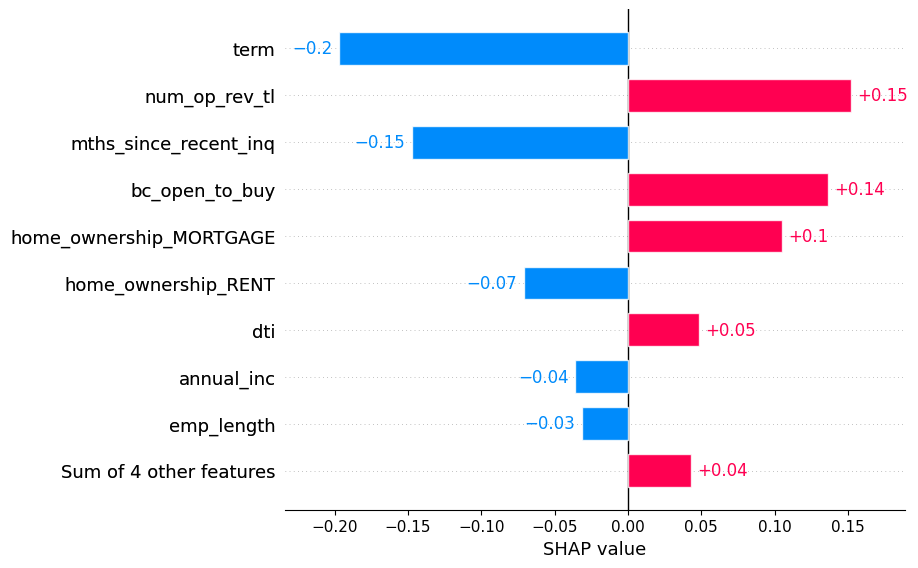

In [112]:
print('Result Interpretability - Applicant Level')
shap.initjs()
explainer = shap.Explainer(model, X_train)
shap_values = explainer(user_input)
fig = shap.plots.bar(shap_values[0])
# st.pyplot(fig)



Model Interpretability - Overall


100%|===================| 268825/269062 [08:19<00:00]        

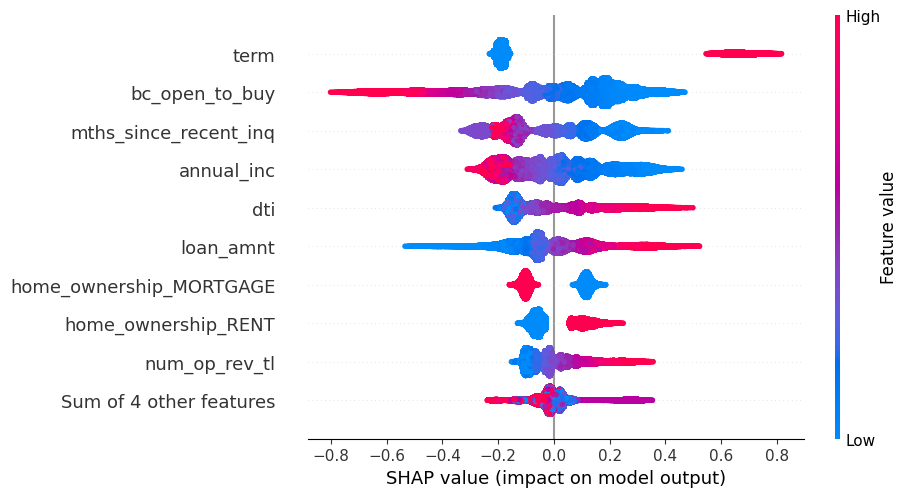

In [127]:
print('Model Interpretability - Overall')
X_test = pd.read_csv("input/Val.csv")
X_test.set_index('id',inplace=True)
X_test = X_test.drop(columns=['target'])

# Cria uma figura do matplotlib
plt.figure(figsize=(10,5))
shap_values_ttl = explainer(X_test)
shap.plots.beeswarm(shap_values_ttl,show=False)
# st.pyplot(fig_ttl)
# Salva a figura
plt.savefig('images/shap_plot.png')